# Atypical Quantum Maps, Analysis

In [52]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from lindblad_channels import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Recover SPAM and Map

### Generate True Model, Full POVM and Inital

In [53]:
[[channel_target1, channel_target2, channel_target3, channel_target4],
 [model1, model2, model3, model4]]= loader(data_path("atypical_maps_benchmark.model"))

spectrum_target1 = channel_spectrum(channel_target1)
spectrum_target2 = channel_spectrum(channel_target2)
spectrum_target3 = channel_spectrum(channel_target3)
spectrum_target4 = channel_spectrum(channel_target4)

spectrum_model1 = channel_spectrum(model1.channel)
spectrum_model2 = channel_spectrum(model2.channel)
spectrum_model3 = channel_spectrum(model3.channel)
spectrum_model4 = channel_spectrum(model4.channel)

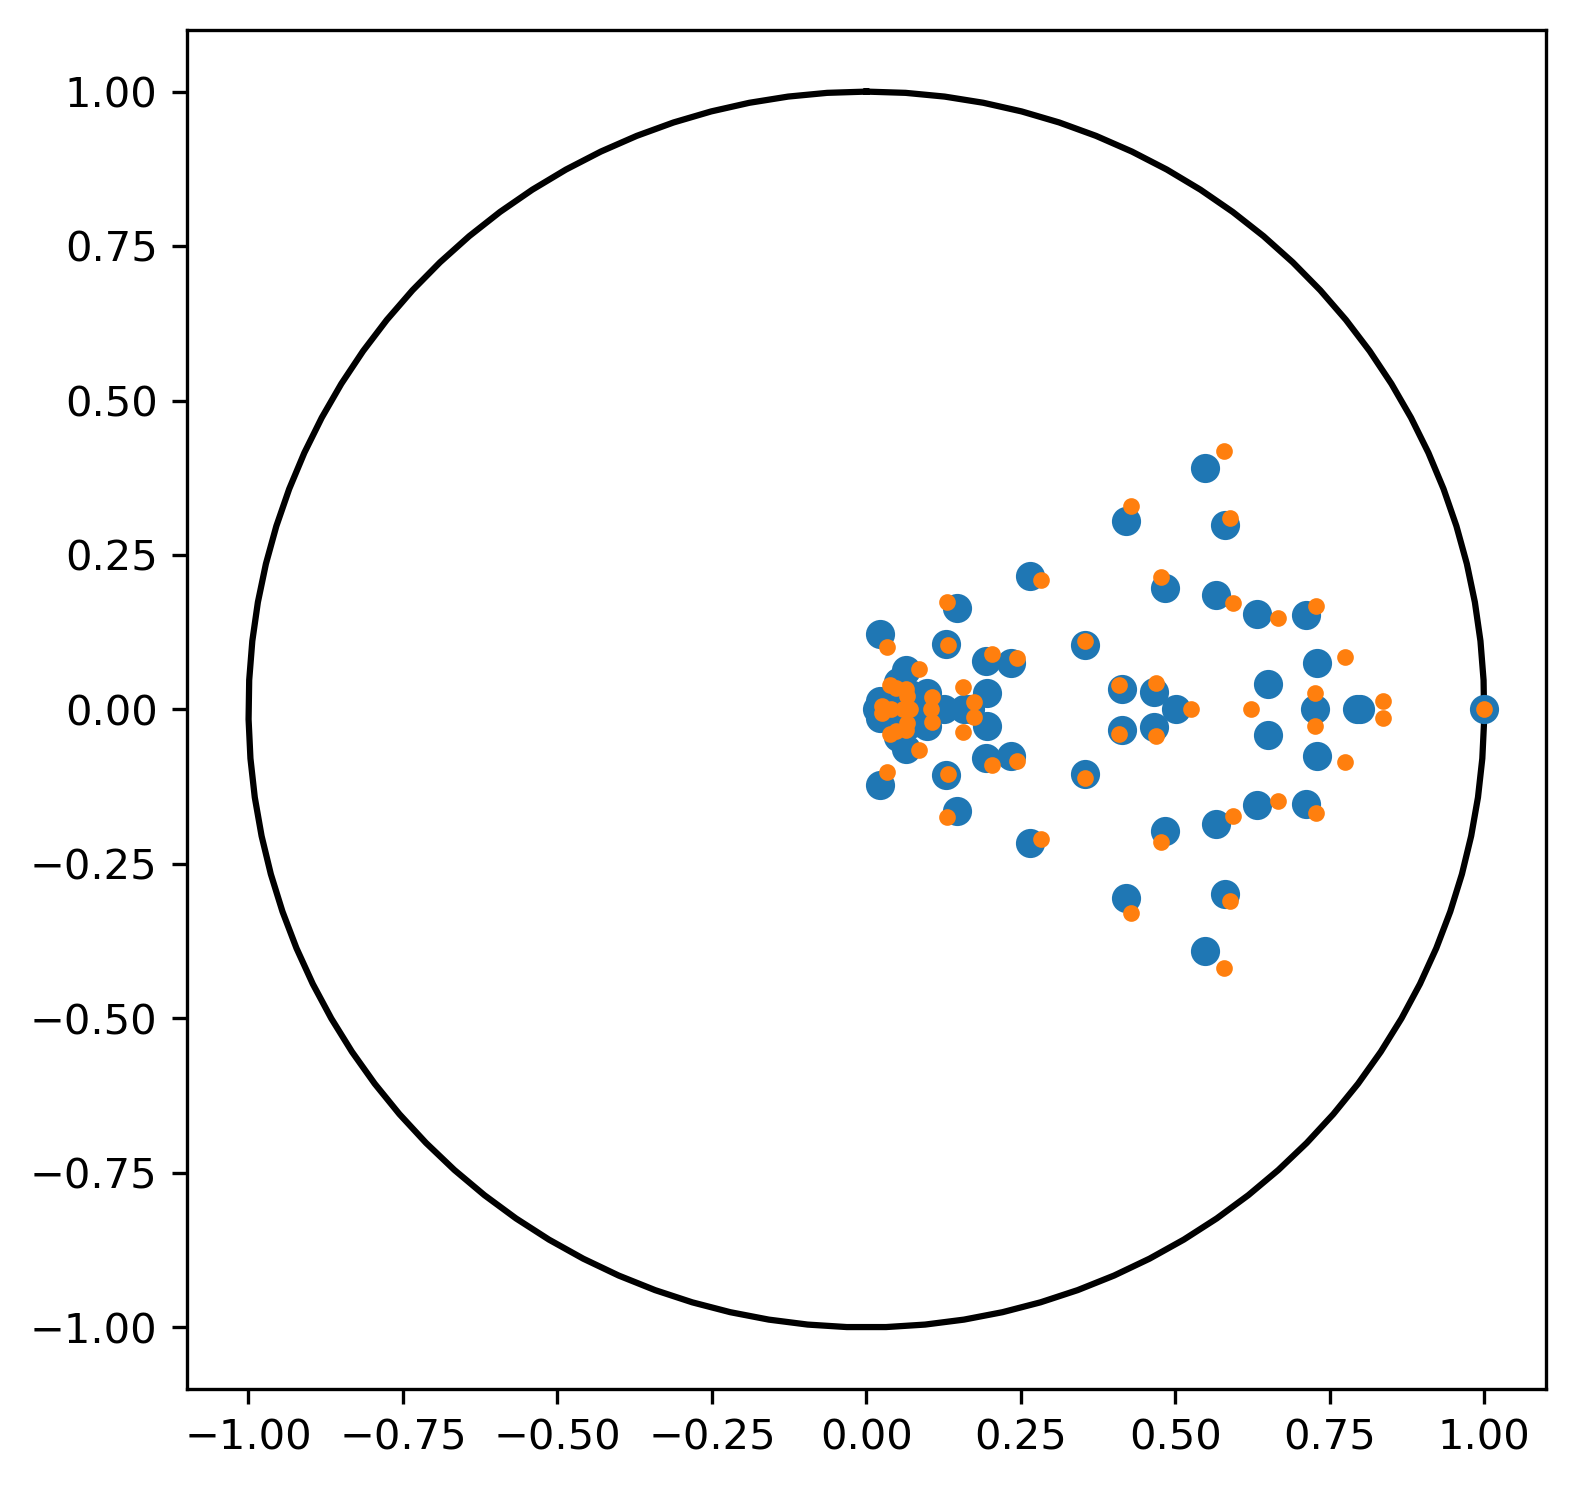

In [54]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_target1[:,0], spectrum_target1[:,1], "o", markersize=3)
plt.show()

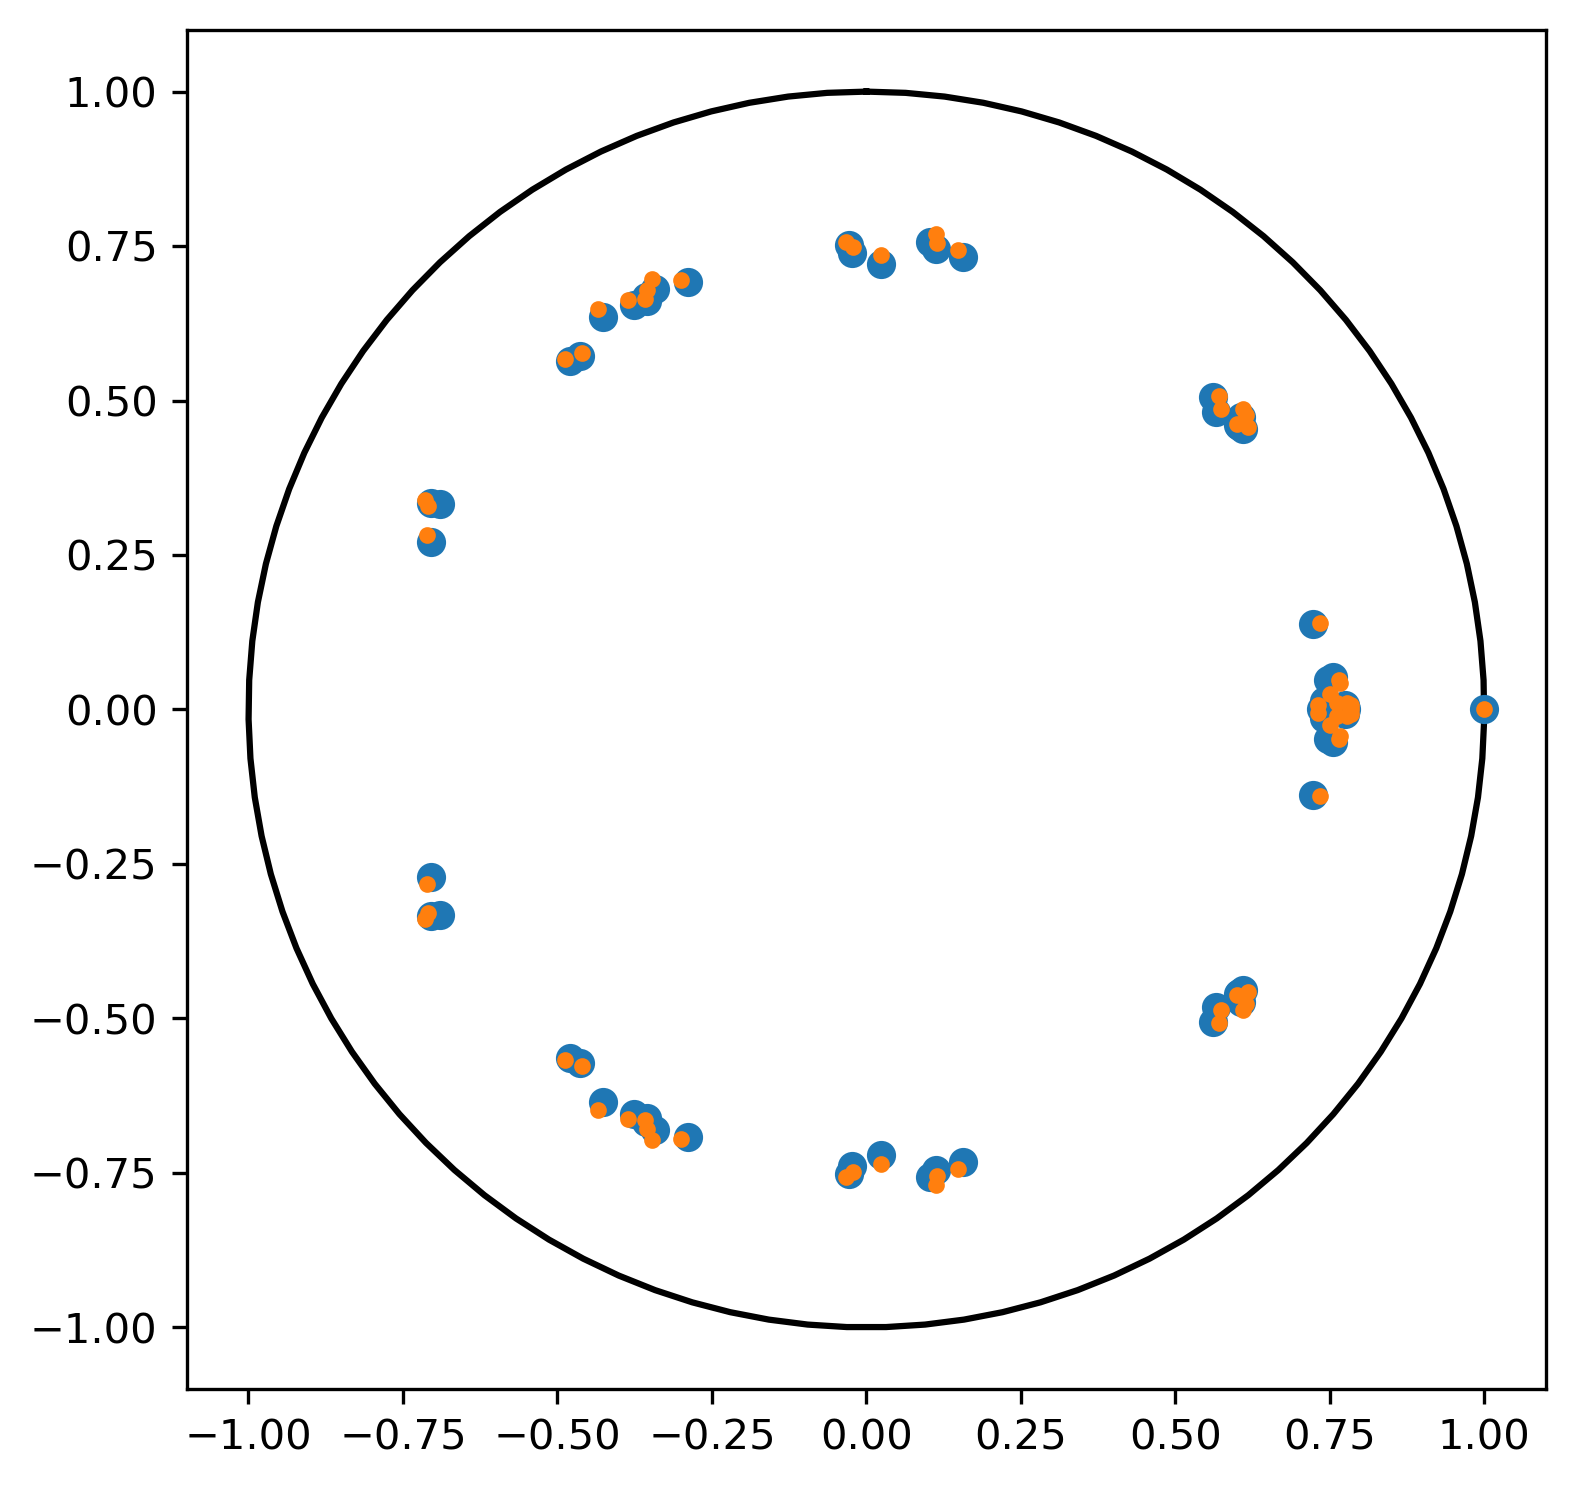

In [55]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_target2[:,0], spectrum_target2[:,1], "o", markersize=3)
plt.show()

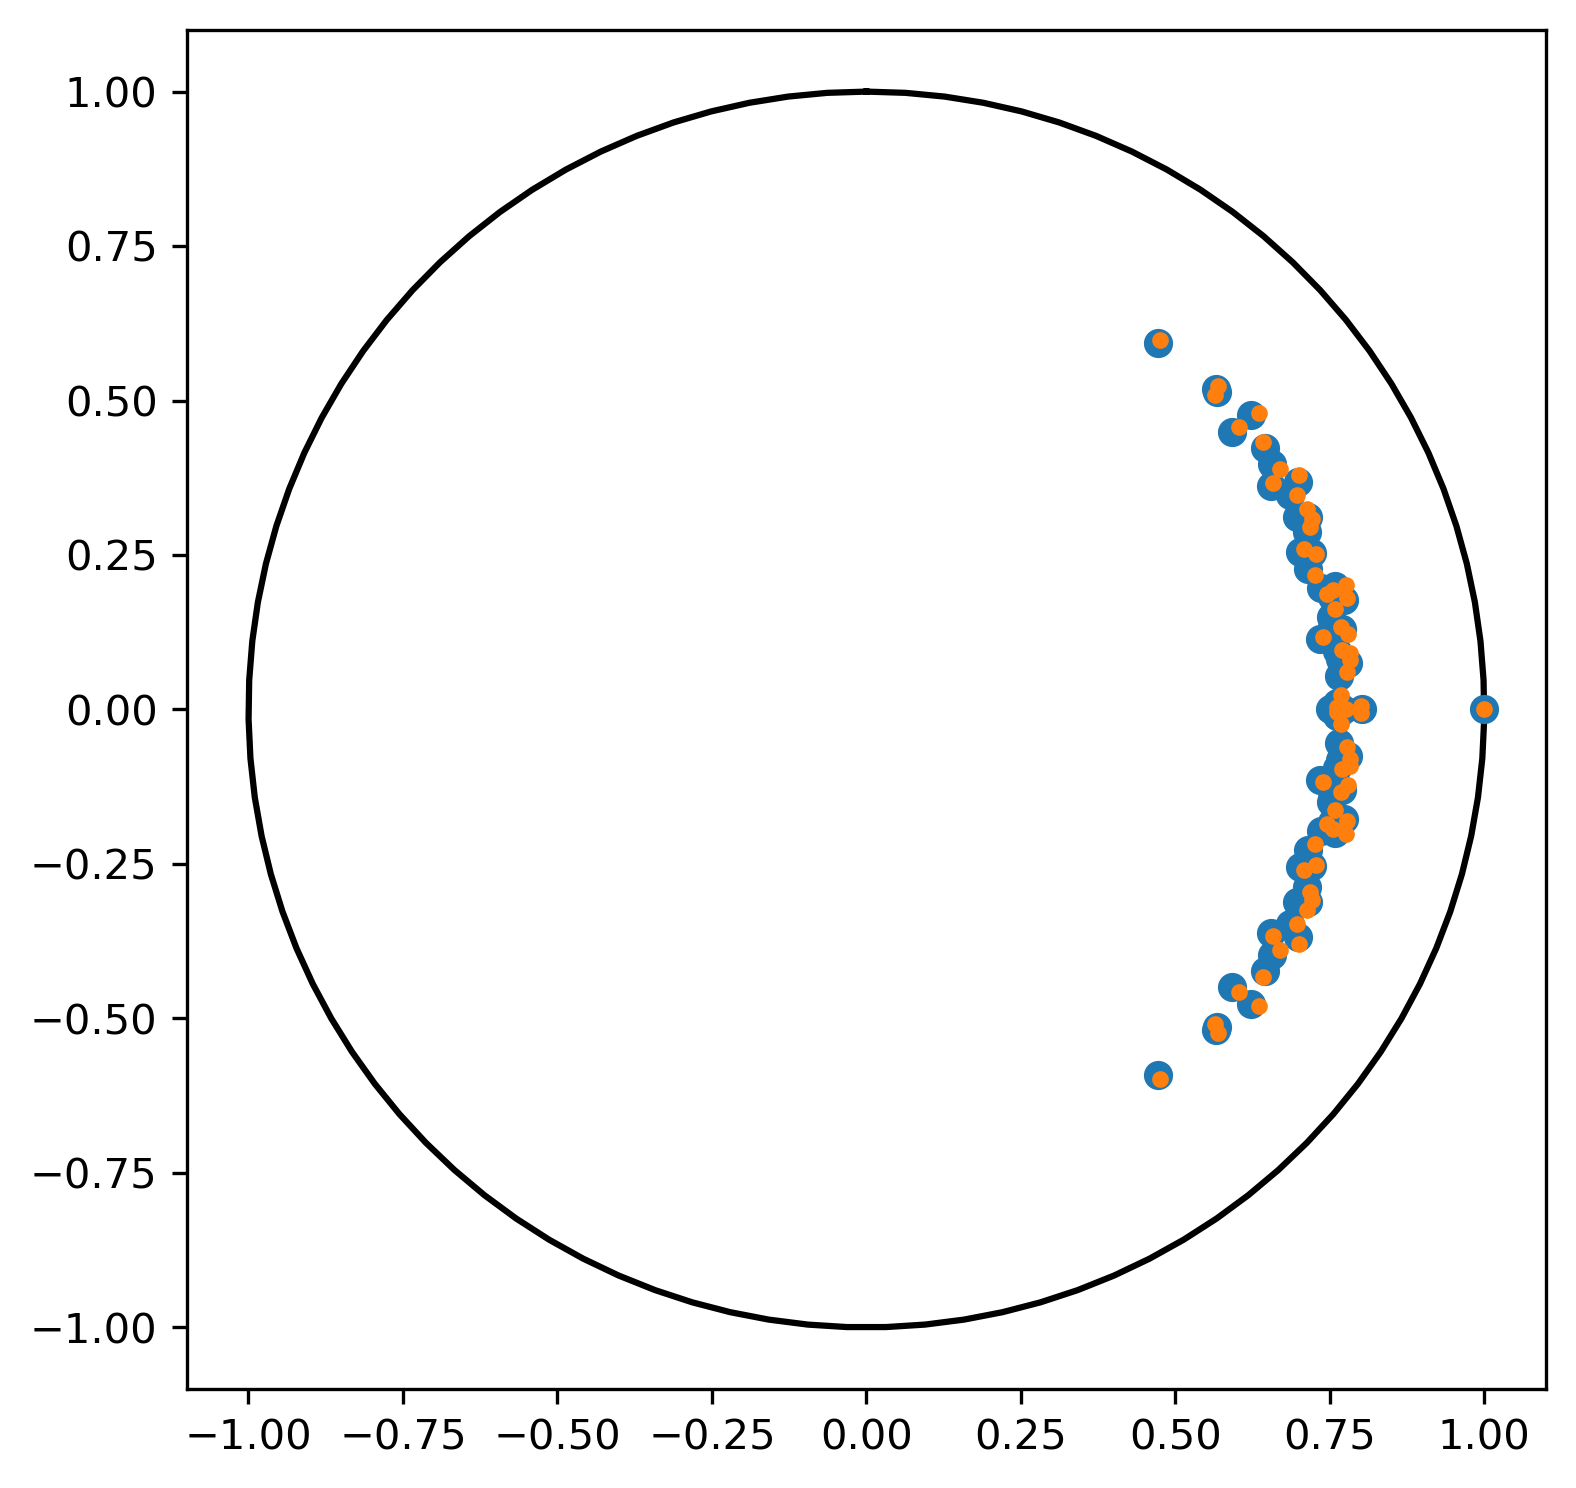

In [56]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.plot(spectrum_target3[:,0], spectrum_target3[:,1], "o", markersize=3)
plt.show()

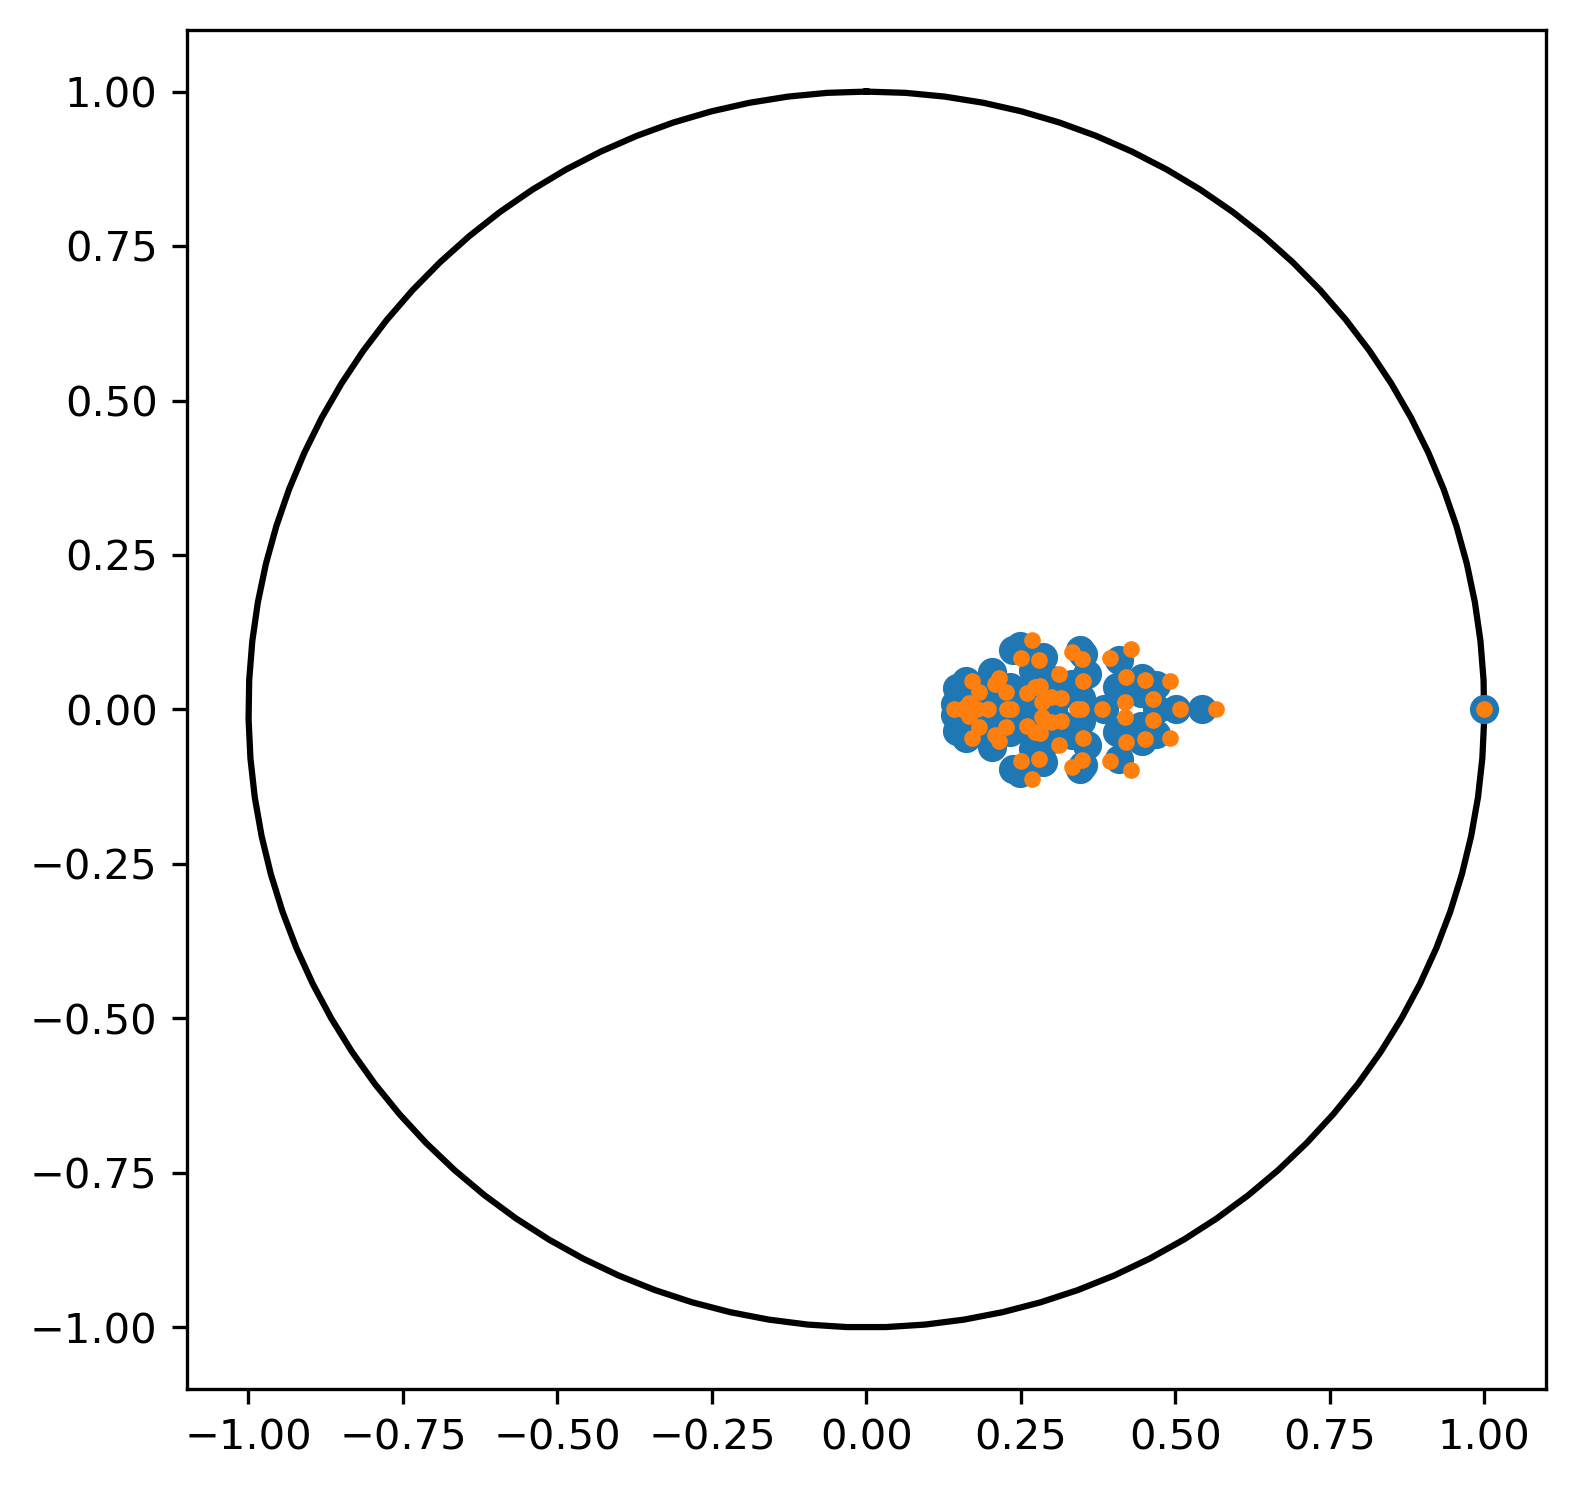

In [57]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model4[:,0], spectrum_model4[:,1], "o")
plt.plot(spectrum_target4[:,0], spectrum_target4[:,1], "o", markersize=3)
plt.show()

## Sample and Noise Sensitivity

In [60]:
[[channel_target], [model_ns1, model_ns2, model_ns3]] = loader(data_path("atypical_maps_robustness.model"))

spectrum_target = channel_spectrum(channel_target)

spectrum_model1 = channel_spectrum(model_ns1.channel)
spectrum_model2 = channel_spectrum(model_ns2.channel)
spectrum_model3 = channel_spectrum(model_ns3.channel)

C:\Users\krist\AppData\Local\Temp\ipykernel_12596\2171647831.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F402D7BEE0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth"], loc="lower left")


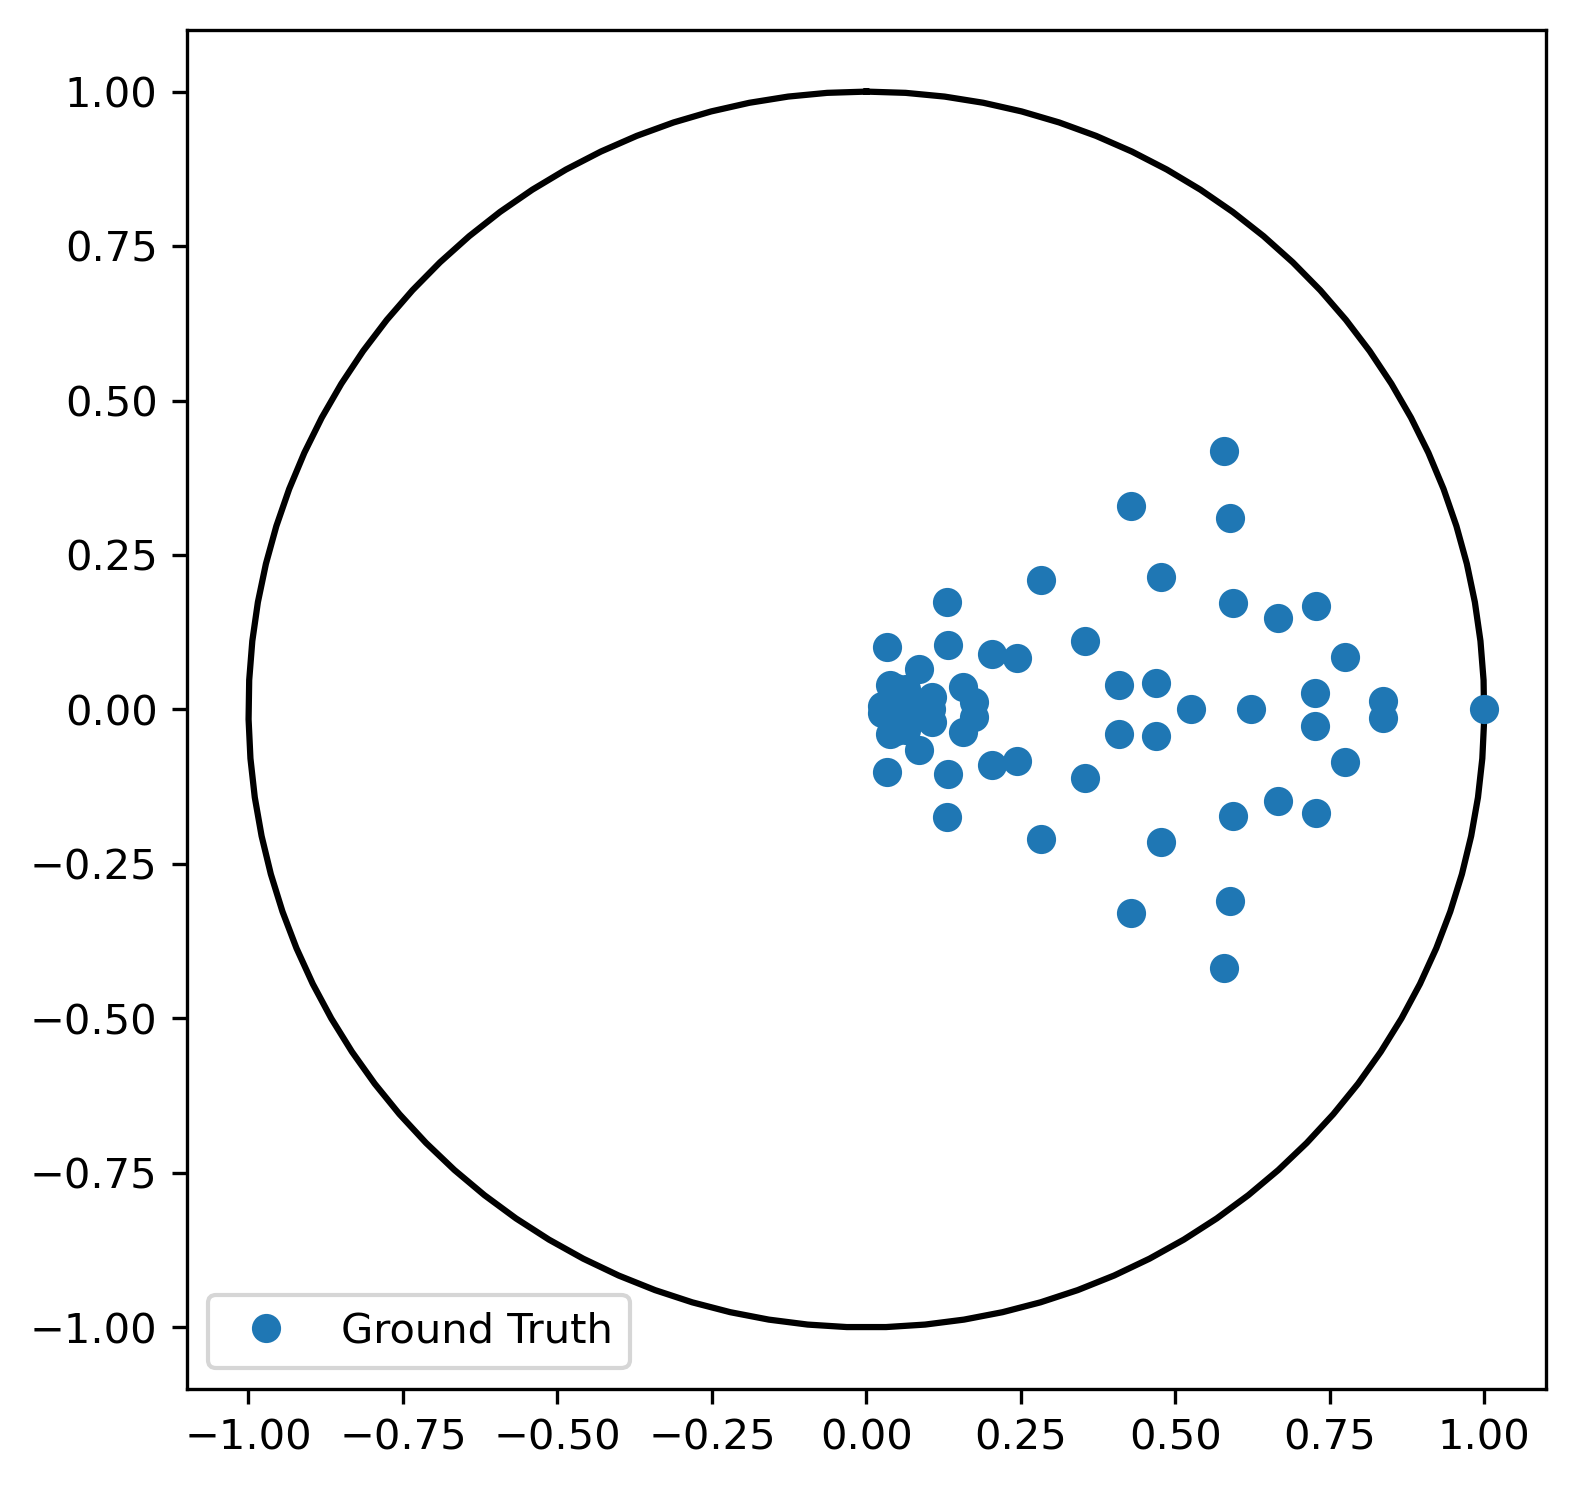

In [61]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_12596\3589216058.py:10: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F402E013F0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$10^2$, Samples=250"], loc="lower left")


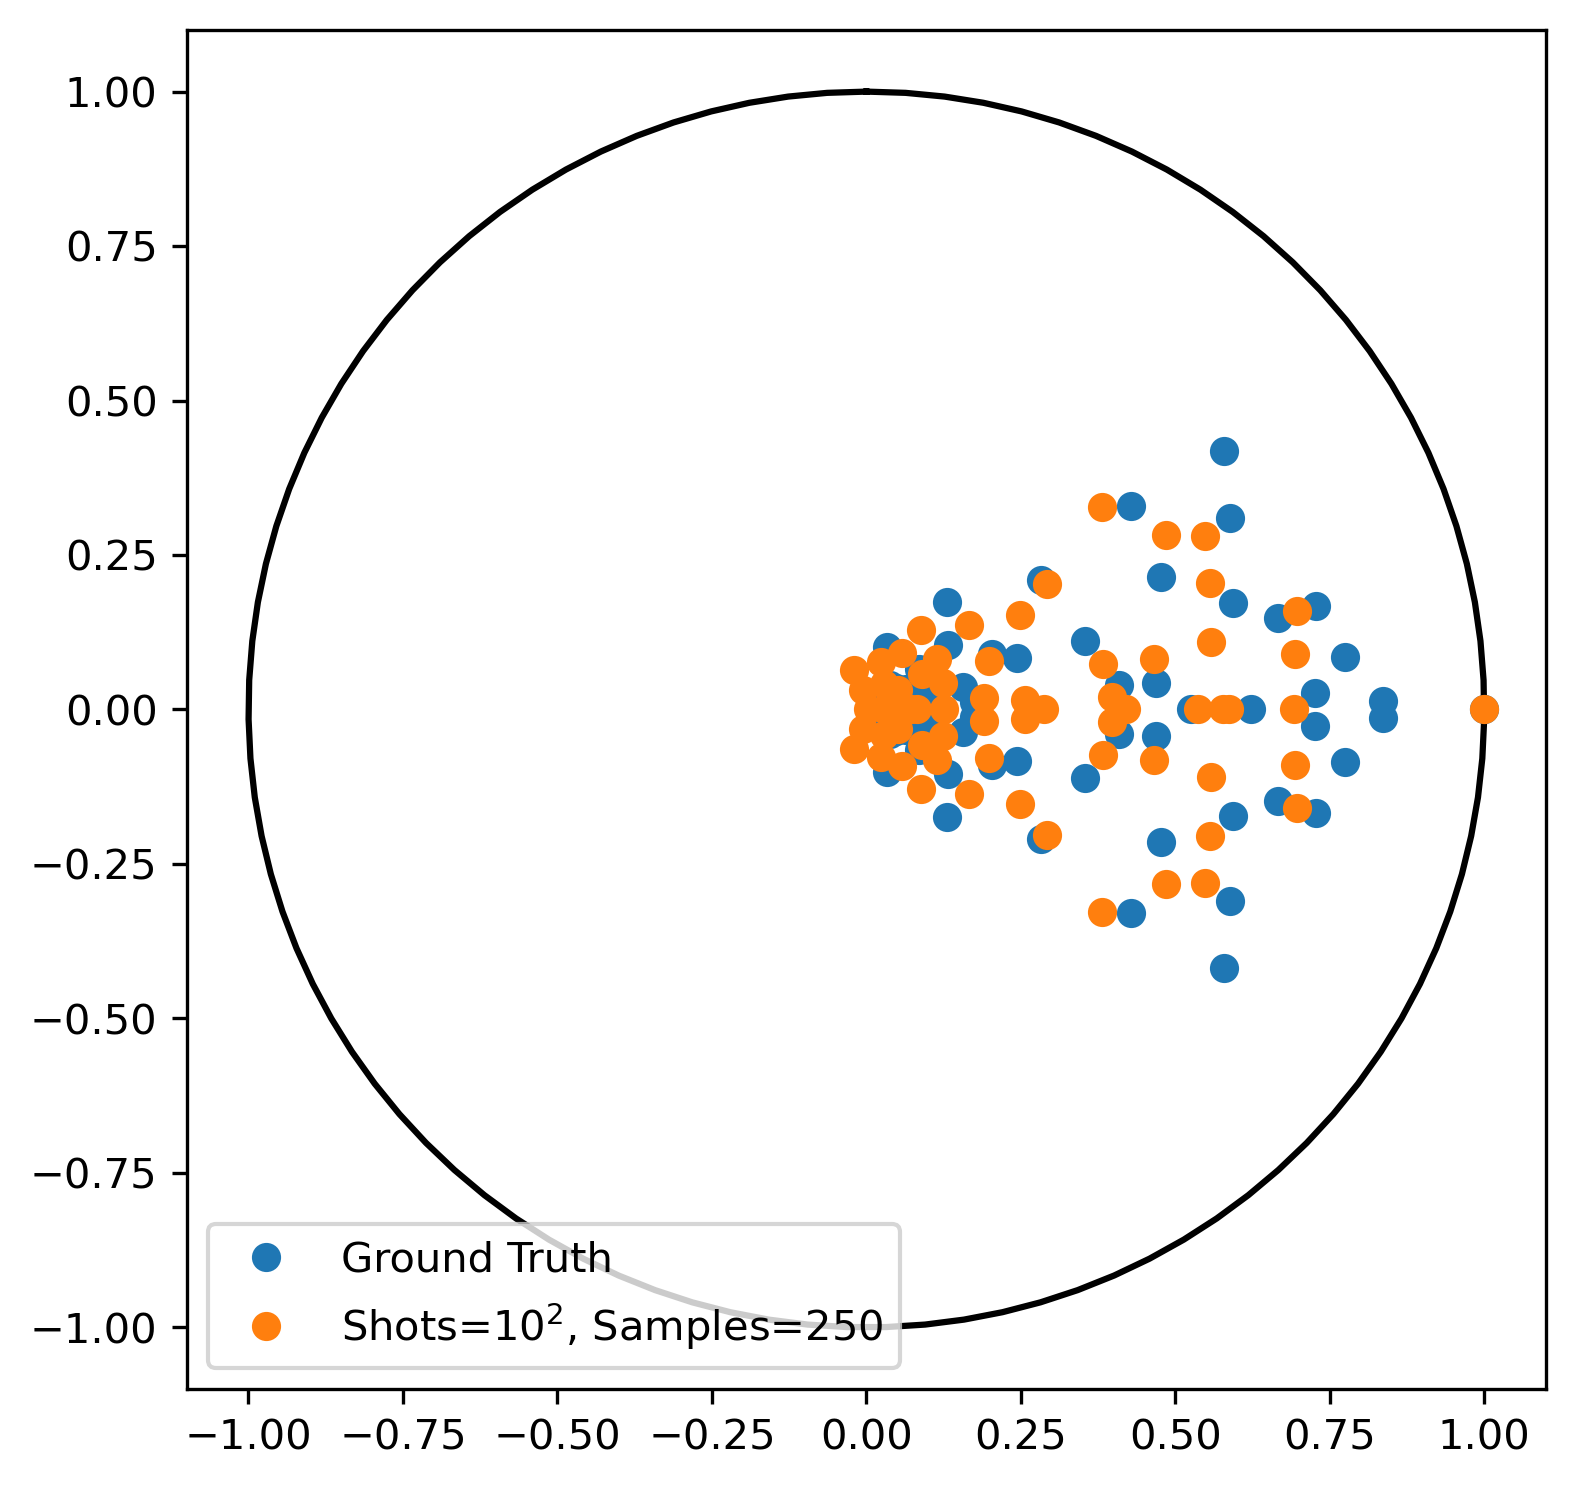

In [62]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.legend(["_","Ground Truth", "Shots=$10^2$, Samples=250"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_12596\2971609546.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F4082AA050> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Ground Truth","Shots=$10^4$, Samples=1000"], loc="lower left")


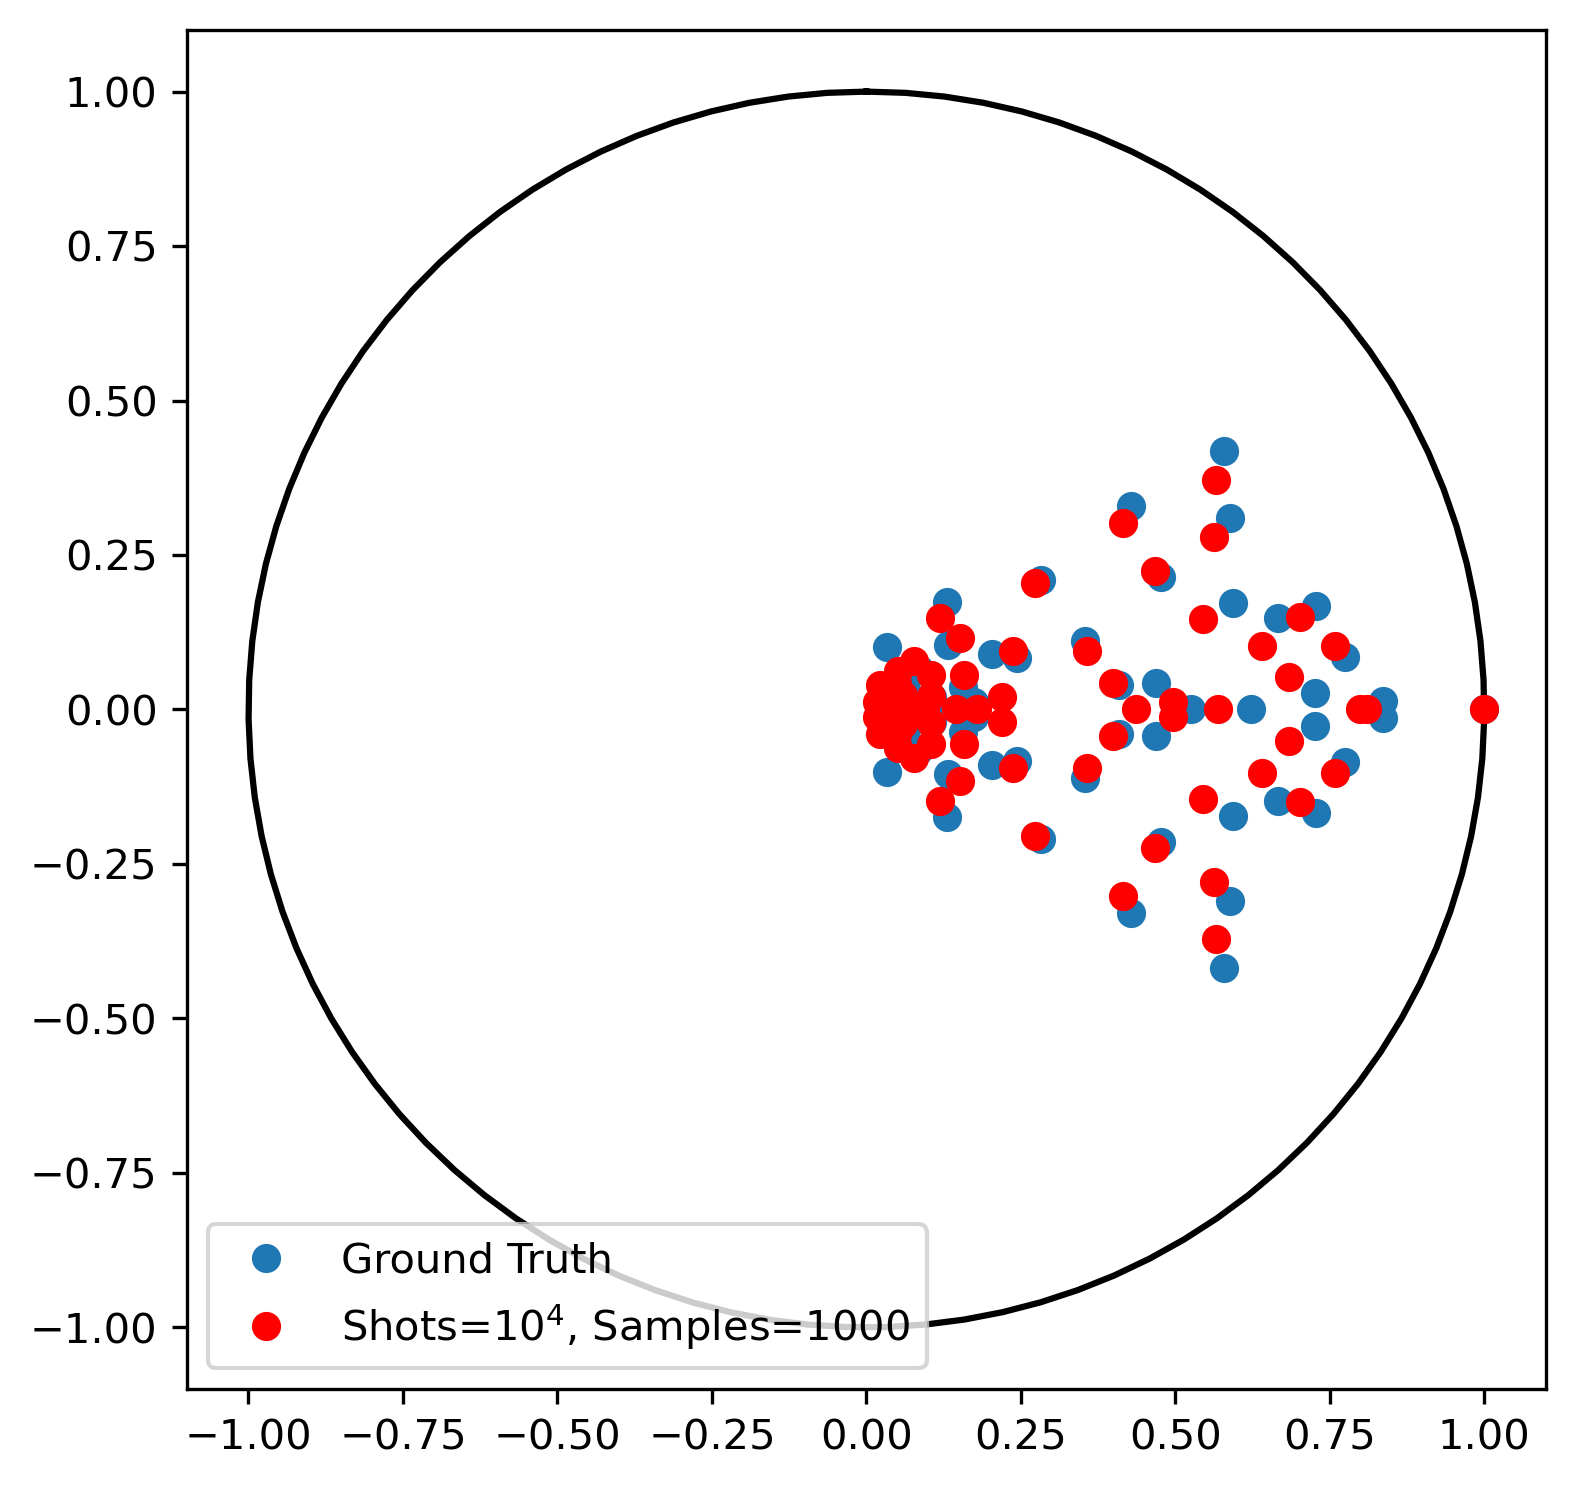

In [63]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_", "Ground Truth","Shots=$10^4$, Samples=1000"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_12596\2929904420.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F402E28FD0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$\infty$, #Samples=4000"], loc="lower left")


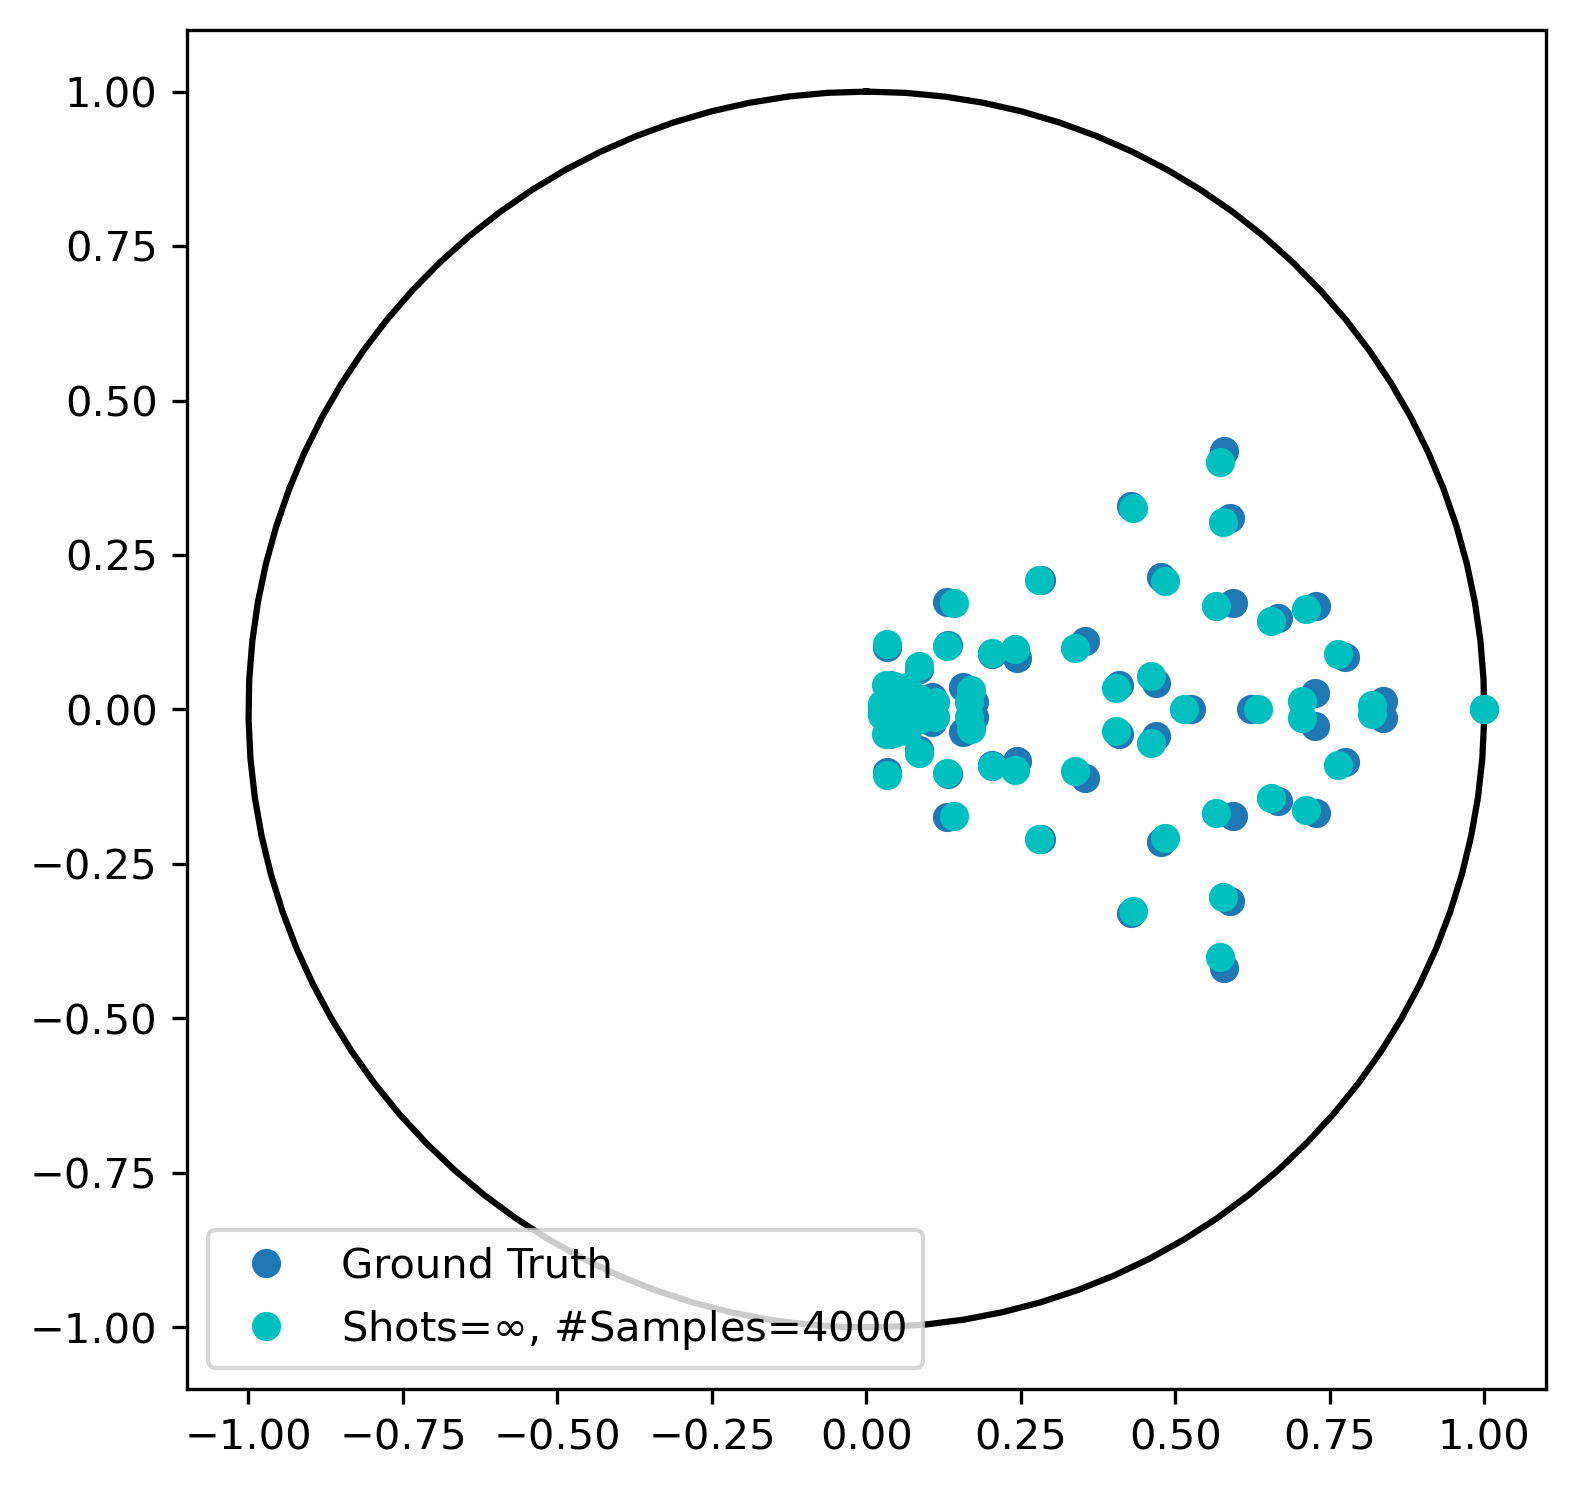

In [64]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "co")
plt.legend(["_","Ground Truth", "Shots=$\infty$, #Samples=4000"], loc="lower left")
plt.show()